In [1]:
#Importing neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from datetime import timedelta
from datetime import datetime
import datetime as dt
from pandas.tseries.offsets import Day, MonthEnd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from haversine import haversine # for calculating haversine distance
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor



In [2]:
#Importing csv for train and test
taxi_train=pd.read_csv('D:/DNB/Material/ML/NYC_Taxi_Trip/train.csv')
taxi_test=pd.read_csv('D:/DNB/Material/ML/NYC_Taxi_Trip/test.csv')

In [3]:
taxi_train.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
print("Total columns in train dataset=>", taxi_train.shape[0])
print("Total columns in test dataset=>", len(taxi_test))
print("Minimum pickup date=>", min(taxi_train.pickup_datetime))
print("Minimum dropoff date=>", min(taxi_train.dropoff_datetime))
print("Maximum pickup date=>", max(taxi_train.pickup_datetime))
print("Maximum dropoff date=>", max(taxi_train.dropoff_datetime))

Total columns in train dataset=> 1458644
Total columns in test dataset=> 625134
Minimum pickup date=> 2016-01-01 00:00:17
Minimum dropoff date=> 2016-01-01 00:03:31
Maximum pickup date=> 2016-06-30 23:59:39
Maximum dropoff date=> 2016-07-01 23:02:03


In [4]:
##To see any  Trip duration and difference in pickup and drop time are same
taxi_train['pickup_datetime'] = pd.to_datetime(taxi_train['pickup_datetime'])
taxi_train['dropoff_datetime'] = pd.to_datetime(taxi_train['dropoff_datetime'])
taxi_train['Diff_time']=taxi_train.dropoff_datetime-taxi_train.pickup_datetime
taxi_train['Diff_time']=taxi_train['Diff_time'] / np.timedelta64(1, 's')
taxi_train['Diff_time'].astype(int).head()
#Returning no difference between Diff Time and trip duration
np.where(taxi_train['Diff_time']!=taxi_train['trip_duration'])

(array([], dtype=int32),)

In [37]:
#Checking null values and dtypes
print("\nSumming Null values=>\n-----------------\n", taxi_train.isnull().sum(),taxi_train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 12 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
Diff_time             1458644 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(3), object(2)
memory usage: 122.4+ MB

Summing Null values=>
-----------------
 id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0


In [4]:
#printing unique values in all columns
import numpy as np
columnList=list(taxi_train)
for c in columnList:
    print(c, 'values', np.unique(taxi_train[c].values), '\n')

id values ['id0000001' 'id0000003' 'id0000005' ..., 'id3999998' 'id3999999'
 'id4000000'] 

vendor_id values [1 2] 

pickup_datetime values ['2016-01-01T00:00:17.000000000' '2016-01-01T00:00:53.000000000'
 '2016-01-01T00:01:01.000000000' ..., '2016-06-30T23:59:10.000000000'
 '2016-06-30T23:59:37.000000000' '2016-06-30T23:59:39.000000000'] 

dropoff_datetime values ['2016-01-01T00:03:31.000000000' '2016-01-01T00:05:54.000000000'
 '2016-01-01T00:07:13.000000000' ..., '2016-07-01T20:17:00.000000000'
 '2016-07-01T22:10:26.000000000' '2016-07-01T23:02:03.000000000'] 

passenger_count values [0 1 2 3 4 5 6 7 8 9] 

pickup_longitude values [-121.93334198 -121.93323517  -79.56973267 ...,  -65.89738464  -65.84838867
  -61.33552933] 

pickup_latitude values [ 34.35969543  34.7122345   35.08153152 ...,  43.91176224  44.37194443
  51.88108444] 

dropoff_longitude values [-121.93330383 -121.93320465  -80.3554306  ...,  -65.89738464  -65.84838867
  -61.33552933] 

dropoff_latitude values [ 32.181140

In [8]:
df_train_agg = taxi_train.groupby('passenger_count')['trip_duration'].aggregate(np.median).reset_index()
df_train_agg

,passenger_count,trip_duration
0,0,20.5
1,1,654.0
2,2,689.0
3,3,688.0
4,4,698.0
5,5,670.0
6,6,662.0
7,7,19.0
8,8,104.0
9,9,560.0


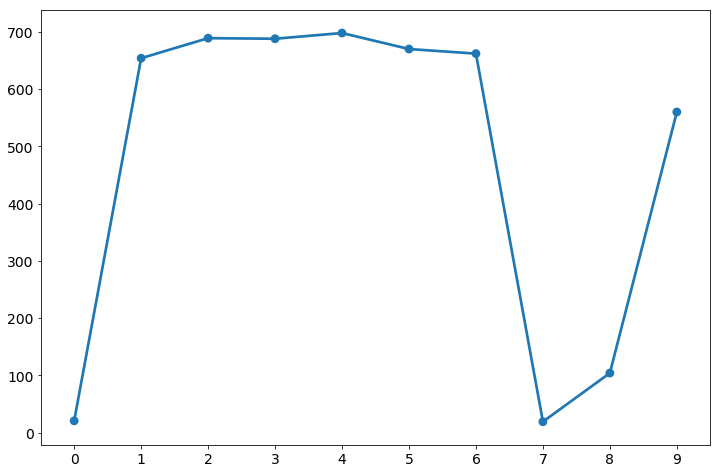

In [7]:

plt.figure(figsize=(12,8))
sns.pointplot(df_train_agg.passenger_count.values, df_train_agg.trip_duration.values)
plt.show()

In [3]:
#feature exteraction
taxi_train['pickup_date'] = pd.to_datetime(taxi_train['pickup_datetime'])
taxi_train['pickup_Day_of_Week'] = taxi_train['pickup_date'].dt.dayofweek
taxi_train['hour'] = taxi_train['pickup_date'].dt.hour
taxi_train['minute'] = taxi_train['pickup_date'].dt.minute
taxi_train['day'] = taxi_train['pickup_date'].dt.day
taxi_train['month'] = taxi_train['pickup_date'].dt.month
taxi_train['IsWeekend'] = taxi_train['pickup_Day_of_Week'].apply(lambda x : 0 if x==0 | x==6 else 1)

In [5]:
taxi_train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Diff_time,pickup_date,pickup_Day_of_Week,hour,minute,day,month,IsWeekend
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,455.0,2016-03-14 17:24:55,0,17,24,14,3,1
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,663.0,2016-06-12 00:43:35,6,0,43,12,6,0


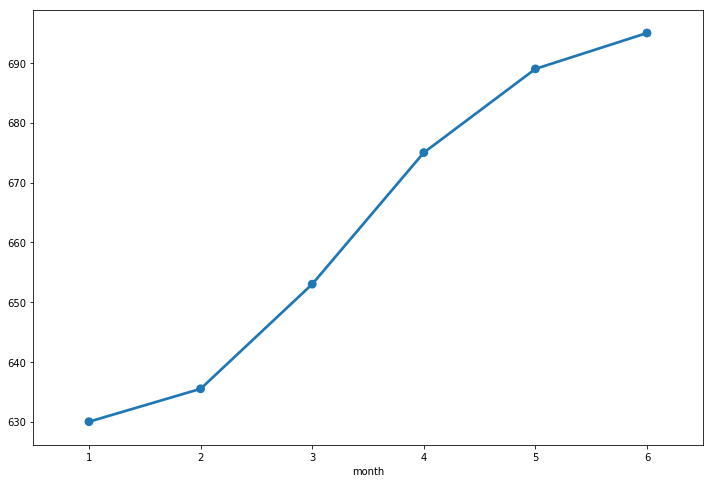

In [4]:
df_train_month_agg = taxi_train.groupby('month')['trip_duration'].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(df_train_month_agg.month,df_train_month_agg.trip_duration.values)
plt.show()

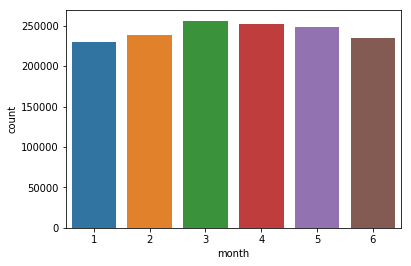

In [67]:
sns.countplot(x="month", data=taxi_train)


In [44]:
Count_Trip_days=taxi_train.groupby('pickup_Day_of_Week')['trip_duration'].sum()
Count_Trip_days

pickup_date_Weekday
0    168291588
1    199396165
2    204977265
3    220000994
4    221347786
5    209394167
6    176149682
Name: trip_duration, dtype: int64

In [45]:
sns.countplot(x="pickup_Day_of_Week", data=taxi_train)


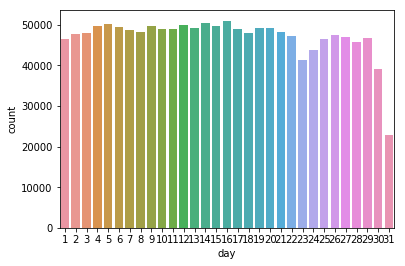

In [36]:
sns.countplot(x="day", data=taxi_train)


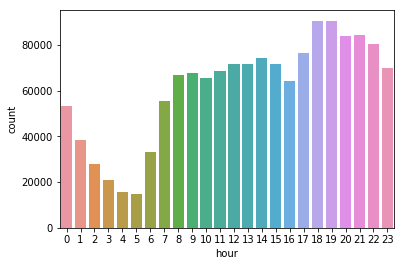

In [33]:
sns.countplot(x="hour", data=taxi_train)


In [11]:
# Convert to numeric #
map_dict = {'N':0, 'Y':1}
taxi_train['store_and_fwd_flag'] = taxi_train['store_and_fwd_flag'].map(map_dict)
taxi_test['store_and_fwd_flag'] = taxi_test['store_and_fwd_flag'].map(map_dict)

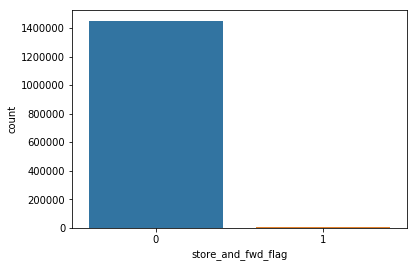

In [55]:
sns.countplot(x="store_and_fwd_flag", data=taxi_train)

In [6]:
#Testing how haversine works
def hav_dist(a,b,c,d):
    haversine((a,b),(c,d), miles=False)
haversine((45.7597, 4.8422), (48.8567, 2.3508), miles=False)

392.21671780659625

In [4]:
#Actual row 
def calculate_haversine_distance(var_row):
    return haversine((var_row["pickup_latitude"], var_row["pickup_longitude"]), 
                     (var_row["dropoff_latitude"], var_row["dropoff_longitude"]), miles = True)



taxi_train["haversine_distance"] = taxi_train.apply(lambda row: calculate_haversine_distance(row), axis=1)

In [5]:
taxi_train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_Day_of_Week', 'hour', 'minute',
       'day', 'month', 'IsWeekend', 'haversine_distance'],
      dtype='object')

In [8]:
taxi_train.head(2)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Diff_time,pickup_date,pickup_Day_of_Week,hour,minute,day,month,IsWeekend,haversine_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,455.0,2016-03-14 17:24:55,0,17,24,14,3,1,0.931137
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,663.0,2016-06-12 00:43:35,6,0,43,12,6,0,1.121890


In [30]:
#to trim the values, check if memory error comes
taxi_train_100000=taxi_train.loc[:100000]
taxi_train_100000.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,Diff_time,pickup_date,pickup_date_Weekday,hour,minute,day,month,haversine_distance,pickup_Day_of_Week,IsWeekend
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,455.0,2016-03-14 17:24:55,0,17,24,14,3,0.931137,0,1
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,663.0,2016-06-12 00:43:35,6,0,43,12,6,1.121890,6,0


In [34]:
#Using decision tree to determine feature importance
from sklearn.preprocessing import Imputer
from sklearn import tree
from sklearn import metrics
y=taxi_train_100000['trip_duration'].values
columns = [ 'vendor_id',
       'passenger_count', 'hour', 'minute', 'day', 'month', 'haversine_distance',
       'pickup_Day_of_Week', 'IsWeekend']

In [36]:
#taken only initial 1L rows to overcome memory Error
features = taxi_train_100000[list(columns)].values


In [41]:
my_tree_one = tree.DecisionTreeClassifier(criterion="gini", max_depth=3)
my_tree_one = my_tree_one.fit(features, y)

In [42]:
print(my_tree_one.feature_importances_) 


[ 0.  0.  0.  0.  0.  0.  1.  0.  0.]


In [5]:
#Outlier Handling

print("Before removing outliers", len(taxi_train)) 
taxi_train_actual=taxi_train[(taxi_train.trip_duration <  taxi_train.trip_duration.quantile(.95)) & (taxi_train.hour.isin([8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])) & (taxi_train.passenger_count.isin([1,2,3,4,5,6]))]
print("After removing outliers", len(taxi_train_actual)) 

Before removing outliers 1458644
After removing outliers 1132589


In [10]:
taxi_train_actual.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
Diff_time             0
pickup_date           0
pickup_Day_of_Week    0
hour                  0
minute                0
day                   0
month                 0
IsWeekend             0
haversine_distance    0
dtype: int64

In [6]:
#taking backup of features for scaling
df=taxi_train_actual[['hour','passenger_count','pickup_Day_of_Week', 'haversine_distance']]
df.head()

,hour,passenger_count,pickup_Day_of_Week,haversine_distance
0,17,1,0,0.931137
3,19,1,2,0.923046
4,13,1,5,0.738554
5,22,6,5,0.682851
6,22,4,4,0.824111


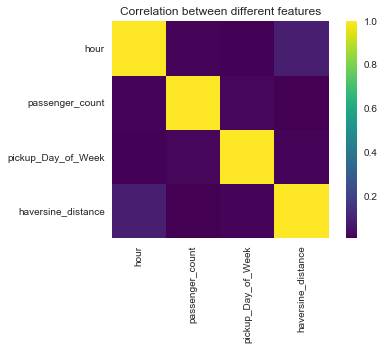

In [11]:
%matplotlib inline
correlation = df.corr()
sns.heatmap(correlation, vmax=1, square=True,cmap='viridis')
plt.title('Correlation between different features')

In [7]:
# Using Min Max Scaler for Scaling the features values
scld = MinMaxScaler(feature_range=(0,1))
arr_scld=scld.fit_transform(df)
df_scld=pd.DataFrame(arr_scld, columns=df.columns)
df_scld.head()


,hour,passenger_count,pickup_Day_of_Week,haversine_distance
0,0.600000,0.0,0.000000,0.001208
1,0.733333,0.0,0.333333,0.001197
2,0.333333,0.0,0.833333,0.000958
3,0.933333,1.0,0.833333,0.000886
4,0.933333,0.6,0.666667,0.001069


In [76]:
df_scld_100000=df_scld.loc[:100000]


In [7]:
# define a function that accepts a list of features and returns testing RMSE
def train_test_rmse(feature_cols):
    X = df_scld[feature_cols]
    y = taxi_train_actual.trip_duration
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [22]:
#Fitting Linear Regression and printing coefficients
X=df_scld
y=taxi_train_actual['trip_duration']
# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)
# print the coefficients
print (linreg.intercept_)
print (linreg.coef_)

600.716638097
[ -1.02928043e+02   1.43741872e+01  -5.78208151e+01   1.02110828e+05]


In [23]:
#Predicing
y_prd=linreg.predict(X)

In [24]:
#Comparing the model to find difference
y_prd=y_prd.astype(int)
actual=taxi_train_actual.trip_duration.astype(int)
Diff=round(y_prd-actual)/100
print("Difference in percentage%\n", Diff.head(20))

Difference in percentage%
 0     2.07
3     1.99
4     1.81
5     1.18
6     2.42
8     3.12
9    -3.21
10   -4.66
11   -2.87
12   -4.03
13    3.20
15    3.95
17    0.49
18   -3.45
19    3.64
21    0.24
23   -2.24
25   -4.00
26   -1.69
27    1.11
Name: trip_duration, dtype: float64


In [15]:
#Printing the actual against predicted
compare_act_prd=pd.DataFrame(y_prd, actual )
compare_act_prd.columns=['predicted']
compare_act_prd.tail(20)

,predicted
trip_duration,
488,581
208,616
708,711
1162,830
552,553
554,655
2002,840
244,589
880,748


In [16]:
#Cross Validation R2 score
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(linreg, X, y, scoring="r2", cv=5) 
print("Average mean score in cross val ==>",scores.mean())

Average mean score in cross val ==> 0.312500134628


In [21]:
#RMSE Score
print (train_test_rmse(['hour','passenger_count','pickup_Day_of_Week', 'haversine_distance']))

353.716628353


In [28]:

from xgboost import XGBRegressor
from sklearn.grid_search import GridSearchCV

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [29]:
#Trying XGBoost
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'objective': 'reg:linear'}
optimized_GBM = GridSearchCV(XGBRegressor(**ind_params), cv_params,scoring = 'r2', cv = 5, n_jobs = -1) 
# Optimize for accuracy since that is the metric used in the Adult Data Set notation

In [ ]:
%time optimized_GBM.fit(X, y)

In [ ]:
optimized_GBM.grid_scores_

In [16]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
train_X = X
train_y = y
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
modelxgb = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

NameError: name 'xgb' is not defined

In [10]:
#DecisionTreeRegressor and AdaboostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300)

regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

In [22]:
##Grid Search for Adaboost
clf = AdaBoostRegressor(random_state=0)
parameters = parameters = {'n_estimators':[75,200,500],'learning_rate':[1.0,1.5,2.0]}
grid_obj = GridSearchCV(clf, parameters)
grid_fit = grid_obj.fit(X, y)
best_clf = grid_fit.best_estimator_
best_clf

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=75, random_state=0)

In [17]:
regr_2 = AdaBoostRegressor( base_estimator=None, learning_rate=1.0, n_estimators=75, random_state=0)
regr_2.fit(X, y)
y_2 = regr_2.predict()
y_2

array([  741.68395227,   684.77128314,   685.59203646,   536.99376511,
         617.73868191,   617.73868191,  1318.23433979,  1007.97723938,
        1188.11687324,   741.68395227,   617.73868191,   682.71874785,
         741.68395227,  1285.60043945,   682.71874785,   741.68395227,
        1285.60043945,  1191.78034504,  1332.82736702,  1007.97723938,
         845.37415001,  1317.35136923,  1318.23433979,  1181.51567323,
         741.68395227,   741.68395227,   617.73868191,  1181.51567323,
         741.68395227,  1318.23433979,   741.68395227,   741.68395227,
        1447.98424511,   682.71874785,   741.68395227,  1272.92391507,
        1155.53653783,  1526.32046845,  1194.31417852,   741.68395227,
         741.68395227,  1495.57333587,   741.68395227,   741.68395227,
        1191.78034504,   741.68395227,   741.68395227,  1181.51567323,
         682.71874785,   685.59203646,   741.68395227,  1509.7832473 ,
         617.73868191,   741.68395227,  1320.72045663,   617.73868191,
      